In [1]:
#Import libraries for simulation
import tensorflow as tf
import numpy as np

#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display


2024-07-28 08:36:17.935079: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 08:36:17.937965: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 08:36:17.946692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 08:36:17.960621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 08:36:17.964289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-28 08:36:17.974226: I tensorflow/core/platform/cpu_feature_gu

In [3]:
def DisplayArray(a, fmt='jpeg', rng=[0,1]):
  """Display an array as a picture."""
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  clear_output(wait = True)
  display(Image(data=f.getvalue()))


In [5]:
sess=tf.compat.v1.InteractiveSession()

I0000 00:00:1722142446.586741   22019 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-28 12:54:06.591489: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def laplace(x):
  """Compute the 2D laplacian of an array"""
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv(x, laplace_k)

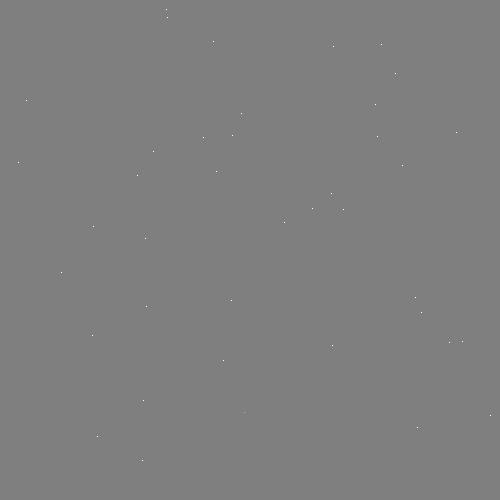

In [8]:
N = 500# Initial Conditions -- some rain drops hit a pond

# Set everything to zero
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

# Some rain drops hit a pond at random points
for n in range(40):
  a,b = np.random.randint(0, N, 2)
  u_init[a,b] = np.random.uniform()

DisplayArray(u_init, rng=[-0.1, 0.1])

In [14]:
## lwf: disable eager execution from the howto 
# https://stackoverflow.com/questions/67796043/tf-placeholder-is-not-compatible-with-eager-execution?noredirect=1
tf.compat.v1.disable_eager_execution()

# Parameters:
# eps -- time resolution
# damping -- wave damping
eps = tf.compat.v1.placeholder(tf.float32, shape=())
damping = tf.compat.v1.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(
  U.assign(U_),
  Ut.assign(Ut_))

In [16]:
# Initialize state to initial conditions
tf.compat.v1.initialize_all_variables().run()

# Run 1000 steps of PDE
for i in range(1000):
  # Step simulation
  step.run({eps: 0.03, damping: 0.04})
  DisplayArray(U.eval(), rng=[-0.1, 0.1])